# COSC 4368 Group Project :'(

Important Information for Jackson's implementation of Agent Class and environment space:
* Gamestate is a list of integers, [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]. 
* Legal Moves is a list of Chars, ["P", "D", "N", "E", "S", "W"]

Below will be the agent class that will create objects with a Q Table and an ID. 

It currently has three non-declaration functions 
1. getLegalMoves(): takes in gamestate and using the ID of the agent derives all legal moves for the agent. returns a list of capital letter chars
2. updateGamestate(): takes in gamestate and nextmove and applies the next move to the game state. returns a list of integers representative of the environment
3. step(): calls previous methods to produce the whole step of the agent given the game state. returns a list of integers representative of the environment and should update the agent's Qtable when appropriate

Todo 
* implement the Q-Table
* implement functions relating to the Q-Table, update, build, etc
* Next Move according to policy needs to be implemented

In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt

The Q-table class uses a constructor that initializes the Q-table with zeros based on the size of the environment and learning parameters. The function get_q_value retrieves the Q-value for a given position-action pair, while update_q_value updates it using the Bellman equation considering the immediate reward and the next position. The print_q_table function displays the Q-table in a readable format, organizing Q-values for each state-action pair. The select_action function chooses an action according to specified policies: randomly from legal moves, with a probability-based exploitation of Q-values, or greedily exploiting Q-values. Finally, the exploit_action function selects an action by exploiting the Q-values, preferring the one with the highest Q-value for the position, randomly breaking ties.

Parameters definitions within Q-Table functions:

* position: A tuple representing the current position (row and column coordinates) of the agent in the environment.
* action: An integer representing the action taken by the agent.
* reward: The immediate reward received by the agent for taking an action.
* next_position: A tuple representing the next position (row and column coordinates) of the agent after taking an action.
* policy: A string representing the policy used for action selection.
* legal_moves: A list of strings representing the legal moves available to the agent from the current position.

In [28]:
class QTable:
    def __init__(self, environment_rows, environment_cols, num_actions, learning_rate, discount_factor):
        # Initialize QTable with environment parameters and zero-initialized Q-values
        self.environment_rows = environment_rows
        self.environment_cols = environment_cols
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((environment_rows, environment_cols, num_actions))

    def set_q_value(self, position, action, new_q_value):
        action_index = self.get_action_index(action)
        self.q_table[position[0]-2, (position[1]-1), action_index] = new_q_value

    def get_q_value(self, position, action):
        action_index = self.get_action_index(action)
        iposition = position[0]-1
        jposition = position[1]-1
        # Retrieve Q-value for a given position-action pair
        return self.q_table[iposition, jposition, action_index]

    def calc_q_value(self, position, action, reward, next_position, next_legal_moves, next_step, learning_method):
        if(action == ""):
            return  # if no action do nothing I think
        # Update Q-value for a given position-action pair using the Bellman equation
        current_q_value = self.get_q_value(position, action)
        if (learning_method == "Q"):
            max_next_q_value = -10000
            for move in next_legal_moves:
                curr_next_q_value = self.get_q_value(next_position, move)
                if (curr_next_q_value > max_next_q_value):
                    max_next_q_value = curr_next_q_value
            new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value)
            self.set_q_value(position, action, new_q_value) 
        # Update Q-value for a given position-action pair using the sarsa update
        if(learning_method == "S"):
            next_q_value = self.get_q_value(next_position, next_step) #Agent.nextstep
            new_q_value =  current_q_value + self.learning_rate * (reward + (self.discount_factor*current_q_value) - next_q_value)
            self.set_q_value(position, action, new_q_value)

    def print_q_table(self):
        # Print the Q-table in a readable format
        print("Q-table:")
        print("State   |     P       D      N      E      S      W")
        print("------------------------------------------------------")
        for row in range(self.environment_rows):
            for col in range(self.environment_cols):
                print(f"({row},{col})   | ", end="")
                for action_idx in range(self.num_actions):
                    q_value_str = f"{self.q_table[row, col, action_idx]:>7.2f}"  
                    print(q_value_str, end="")
                print()



    def select_action(self, position, policy, legal_moves):
        if(len(legal_moves) == 0):
            return ""
        # Select an action based on the specified policy
        if policy == "PRANDOM":
            return random.choice(legal_moves)
        elif policy == "PEXPLOIT":
            # With probability 0.8, exploit the Q-values; otherwise, choose a random action
            if random.random() < 0.8:
                return self.get_best_move(position, legal_moves)
            else:
                return random.choice(legal_moves)
        elif policy == "PGREEDY":
            # Greedily select the action with the highest Q-value
            return self.get_best_move(position, legal_moves)

    def get_best_move(self, position, legal_moves):
        if("P" in legal_moves):
            return "P"
        if("D" in legal_moves):
           return "D"
        
        # Exploit the Q-values by selecting the action with the highest Q-value for the given position
        max_q_value = -10000
        best_move = ""
        for move in legal_moves:
            curr_q_value = self.get_q_value(position, move)
            if(curr_q_value > max_q_value):
                max_q_value = curr_q_value
                best_move = move
        return best_move
    
    def get_action_index(self, action):
        if(action == "P"):
            index = 0
        elif(action == "D"):
            index = 1
        elif(action == "N"):
            index = 2
        elif(action == "E"):
            index = 3
        elif(action == "S"):
            index = 4
        elif(action == "W"):
            index = 5
        else:
            print(f"Action: {action}")
        return index


In [29]:
class Agent():
    # this class is used to define the different agents

    def __init__(self, agentID):
        self.qtable = None              # To be filled out later
        self.agentID = agentID          # Agent ID differentiates agents: Red=0, Blue=1, Black=2    
        self.reward = 0                 # Represents the current rewards this agent has scored
        self.rewardList = []            # Holds the rewards that the agent has scored for each step the agent has been through
        self.nextstep = ""            #Holds the future action to be implemented in SARSA and Step function
    
    # sets reward for picking up
    def setPickupReward(self):
        self.reward += 13

    # sets reward for dropping off
    def setDropoffReward(self):
        self.reward += 13

    # sets penalty for moving
    def setMovePenalty(self):
        self.reward -= 1

    # appends current reward to the list of agent rewards for each step
    def setRewardList(self, reward):
        self.rewardList.append(reward)

    def setAgentQTable(self, environment_rows, environment_cols, num_actions, learning_rate, discount_factor):
        self.qtable = QTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

    def setAgentNextStep(self, nextStep):
        self.nextstep = nextStep

    def getAgentNextStep(self):
        return self.nextstep
    
    # returns current rewards for agents
    def getReward(self):
        return self.reward

    # returns list of 
    def getRewardList(self):
        return self.rewardList
    
    def getPosition(self, gamestate):
        agentI = gamestate[self.agentID*2]
        agentJ = gamestate[self.agentID*2+1]

        return [agentI,agentJ]

    def getNextPosition(self, position, nextMove):
        if(nextMove == "N"):
            position[0] = position[0]-1
        if(nextMove == "S"):
            position[0] = position[0]+1
        if(nextMove == "W"):
            position[1] = position[1]-1
        if(nextMove == "E"):
            position[1] = position[1]+1

        return position
    
    '''
    # returns the possible moves as a tuple of Chars, The tuple is important because the legalmoves should not be changed at any point in the step
    # checks all possible options for the game state and is universal to all agents, always returns the legal i.e. possible moves for instance:
    # dropping up when a box when agent has n o box is not possible -> x.agentid = 1 then D is not a legal move
    # picking up when a box when agent has a box is not possible -> x.agentid = 1 then P is not a legal move
    # moving into a wall -> i or j = 0 or 6 then corresponding move is not a legal move
    # moving into another agent is not possible -> if (i+-1,j) or (i,j+-1) = other agent position then corresponding move is not a legal move
    # if dropoff location has 5, D is not a legal move
    # if pickup location has 0, P is not a legal move   '''
    def getLegalMoves(self, gamestate):
        legalMoves = ["P", "D", "N", "S", "E", "W"]
        positions = gamestate[0:6]
        position = self.getPosition(gamestate)

        ipositions = [positions[0], positions[2], positions[4]]
        agentI = ipositions.pop(self.agentID)

        jpositions = [positions[1], positions[3],  positions[5]]
        agentJ = jpositions.pop(self.agentID)

        otherAgentPositions = [[ipositions[0], jpositions[0]], [ipositions[1], jpositions[1]]]

        agentBox = gamestate[self.agentID+6]

        dropoff = gamestate[9:12]
        dropoffPositions = [[1,1], [3,1], [4,5]]

        pickup = gamestate[12:]
        pickupPositions = [[1,5], [2,4], [5,2]]

        if(agentBox == 0):
            legalMoves.remove("D")
            if([agentI, agentJ] not in pickupPositions):
                legalMoves.remove("P")
            else:
                index = 0
                for location in pickupPositions:
                    if ([agentI, agentJ] == location and pickup[index] == 0):
                        legalMoves.remove("P")
                    index += 1
        else:
            legalMoves.remove("P")
            if([agentI, agentJ] not in dropoffPositions):
                legalMoves.remove("D")
            else:
                index = 0
                for location in dropoffPositions:
                    if ([agentI, agentJ] == location and dropoff[index] == 5):
                        legalMoves.remove("D")
                    index += 1

        if([agentI-1, agentJ] in otherAgentPositions or agentI-1 == 0):
            legalMoves.remove("N")
        if([agentI+1, agentJ] in otherAgentPositions or agentI+1 == 6):
            legalMoves.remove("S")
        if([agentI, agentJ-1] in otherAgentPositions or agentJ-1 == 0):
            legalMoves.remove("W")   
        if([agentI, agentJ+1] in otherAgentPositions or agentJ+1 == 6):
            legalMoves.remove("E")   

        return legalMoves

    # this uses pickup locations for experiment 4
    def getLegalMoves4(self, gamestate):
        legalMoves = ["P", "D", "N", "S", "E", "W"]
        positions = gamestate[0:6]
        position = self.getPosition(gamestate)

        ipositions = [positions[0], positions[2], positions[4]]
        agentI = ipositions.pop(self.agentID)

        jpositions = [positions[1], positions[3],  positions[5]]
        agentJ = jpositions.pop(self.agentID)

        otherAgentPositions = [[ipositions[0], jpositions[0]], [ipositions[1], jpositions[1]]]

        agentBox = gamestate[self.agentID+6]

        dropoff = gamestate[9:12]
        dropoffPositions = [[1,1], [3,1], [4,5]]

        pickup = gamestate[12:]
        pickupPositions = [[4,2], [3,3], [2,4]]

        if(agentBox == 0):
            legalMoves.remove("D")
            if([agentI, agentJ] not in pickupPositions):
                legalMoves.remove("P")
            else:
                index = 0
                for location in pickupPositions:
                    if ([agentI, agentJ] == location and pickup[index] == 0):
                        legalMoves.remove("P")
                    index += 1
        else:
            legalMoves.remove("P")
            if([agentI, agentJ] not in dropoffPositions):
                legalMoves.remove("D")
            else:
                index = 0
                for location in dropoffPositions:
                    if ([agentI, agentJ] == location and dropoff[index] == 5):
                        legalMoves.remove("D")
                    index += 1

        if([agentI-1, agentJ] in otherAgentPositions or agentI-1 == 0):
            legalMoves.remove("N")
        if([agentI+1, agentJ] in otherAgentPositions or agentI+1 == 6):
            legalMoves.remove("S")
        if([agentI, agentJ-1] in otherAgentPositions or agentJ-1 == 0):
            legalMoves.remove("W")   
        if([agentI, agentJ+1] in otherAgentPositions or agentJ+1 == 6):
            legalMoves.remove("E")   

        return legalMoves
    
    # takes the nextmove and returns the corresponding gamestate as a list of integers
    def getGameState(self, gamestate, nextMove):
        agentI = gamestate[self.agentID*2]
        agentJ = gamestate[self.agentID*2+1]

        dropoffPositions = [[1,1], [3,1], [4,5]]
        pickupPositions = [[1,5], [2,4], [5,2]]

        if(nextMove == "D"):
            index = 0
            for location in dropoffPositions:
                if([agentI, agentJ] == location):
                    gamestate[9+index] = gamestate[9+index] + 1
                index += 1
            gamestate[6+self.agentID] = 0

        if(nextMove == "P"):
            index = 0
            for location in pickupPositions:
                if([agentI, agentJ] == location):
                    gamestate[12+index] = gamestate[12+index] - 1
                index += 1
            gamestate[6+self.agentID] = 1

        if(nextMove == "N"):
            gamestate[self.agentID*2] = agentI-1
        if(nextMove == "S"):
            gamestate[self.agentID*2] = agentI+1
        if(nextMove == "W"):
            gamestate[self.agentID*2+1] = agentJ-1
        if(nextMove == "E"):
            gamestate[self.agentID*2+1] = agentJ+1

        return gamestate

    # this uses pickup locations for experiment 4
    def getGameState4(self, gamestate, nextMove):
        agentI = gamestate[self.agentID*2]
        agentJ = gamestate[self.agentID*2+1]

        dropoffPositions = [[1,1], [3,1], [4,5]]
        pickupPositions = [[4,2], [3,3], [2,4]]

        if(nextMove == "D"):
            index = 0
            for location in dropoffPositions:
                if([agentI, agentJ] == location):
                    gamestate[9+index] = gamestate[9+index] + 1
                index += 1
            gamestate[6+self.agentID] = 0

        if(nextMove == "P"):
            index = 0
            for location in pickupPositions:
                if([agentI, agentJ] == location):
                    gamestate[12+index] = gamestate[12+index] - 1
                index += 1
            gamestate[6+self.agentID] = 1

        if(nextMove == "N"):
            gamestate[self.agentID*2] = agentI-1
        if(nextMove == "S"):
            gamestate[self.agentID*2] = agentI+1
        if(nextMove == "W"):
            gamestate[self.agentID*2+1] = agentJ-1
        if(nextMove == "E"):
            gamestate[self.agentID*2+1] = agentJ+1

        return gamestate


    def stepS(self, gamestate, policy):
        learning_method = "S"

        next_move = self.getAgentNextStep()
        position = self.getPosition(gamestate)
        
        if(next_move == ""):
            legal_moves = self.getLegalMoves(gamestate)
            if("P" in legal_moves):
                next_move = "P"
            elif("D" in legal_moves):
                next_move = "D"
            else:
                next_move = random.choice(legal_moves)

        next_position = position
        next_gamestate = self.getGameState(gamestate, next_move)
        next_legal_moves = self.getLegalMoves(next_gamestate)

        if(next_move == "P"):
            self.setPickupReward()
            turn_reward = 13
        elif(next_move == "D"):
            self.setDropoffReward()
            turn_reward = 13
        else:
            self.setMovePenalty()
            next_position = self.getNextPosition(position, next_move)
            next_gamestate = self.getGameState(gamestate, next_move)
            next_legal_moves = self.getLegalMoves(next_gamestate)
            turn_reward = -1

        agent_next_step = self.qtable.get_best_move(next_position, next_legal_moves)    
        self.setAgentNextStep(agent_next_step)

        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, agent_next_step, learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate

    #learning_method is a string_arg passed on as SARSA or empty
    def stepQ(self, gamestate, policy): 
        learning_method = "Q"
        # Get legal moves for the agent
        legal_moves = self.getLegalMoves(gamestate)
        position = self.getPosition(gamestate)
        
        # Select action based on the Q-table and policy, and set agent reward accordingly
        if "P" in legal_moves:
            next_move = "P"
            self.setPickupReward()
            turn_reward=13
        elif "D" in legal_moves:
            next_move = "D"
            self.setDropoffReward()
            turn_reward=13
        else: 
            # If neither pickup nor dropoff is available, use Q-table-based policy
            next_move = self.qtable.select_action(position, policy, legal_moves)
            self.setMovePenalty()
            turn_reward=-1
        
        next_position = self.getNextPosition(position, next_move)
        next_gamestate = self.getGameState(gamestate, next_move)
        next_legal_moves = self.getLegalMoves(next_gamestate)

        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, "NA", learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate
    
    # this is for pickup locations in experiment 4
    def stepQ4(self, gamestate, policy): 
        learning_method = "Q"
        # Get legal moves for the agent
        legal_moves = self.getLegalMoves4(gamestate)
        position = self.getPosition(gamestate)
        
        # Select action based on the Q-table and policy, and set agent reward accordingly
        if "P" in legal_moves:
            next_move = "P"
            self.setPickupReward()
            turn_reward=13
        elif "D" in legal_moves:
            next_move = "D"
            self.setDropoffReward()
            turn_reward=13
        else: 
            # If neither pickup nor dropoff is available, use Q-table-based policy
            next_move = self.qtable.select_action(position, policy, legal_moves)
            self.setMovePenalty()
            turn_reward=-1
        
        next_position = self.getNextPosition(position, next_move)
        next_gamestate = self.getGameState4(gamestate, next_move)
        next_legal_moves = self.getLegalMoves4(next_gamestate)

        self.qtable.calc_q_value(position, next_move, turn_reward, next_position, next_legal_moves, "NA", learning_method)
        self.setRewardList(self.getReward())
        
        return next_gamestate
    


In [30]:
def finishCheck(gamestate):
    if(gamestate[9:] == [5,5,5,0,0,0]):
        return True
    return False

1.	In Experiment 1 you use learning rate=0.3 and discount factor=0.5, and run the traditional Q-learning algorithm for 9000 steps; initially you run the policy PRANDOM for 500 steps, then
* 	Continue running PRANDOM for 8500 more steps  (only policy will change, agents will keep the behavior from the first training)
*	Run PGREEDY for the remaining 8500 steps (only policy will change, agents will keep the behavior from the first training)
*	Run PEXPLOIT for the remaining 8500 steps (only policy will change, agents will keep the behavior from the first training)


Below I am going to run the first 500 steps of prandom

First Random Run: [2, 5, 1, 3, 4, 1, 1, 0, 1, 2, 3, 5, 3, 0, 0]
Red Reward: -96
Blue Reward: -54
Black Reward: -40

Second Run: [3, 2, 3, 3, 4, 3, 0, 1, 0, 0, 1, 3, 4, 2, 4]
Red Reward: -1949
Blue Reward: -1865
Black Reward: -1809

Greedy Run: [2, 3, 4, 3, 1, 2, 0, 0, 0, 0, 0, 0, 5, 5, 5]
Red Reward: -4782
Blue Reward: -4698
Black Reward: -4642

Exploit Run: [1, 4, 2, 5, 2, 2, 0, 0, 1, 5, 5, 4, 0, 0, 0]
Red Reward: -7531
Blue Reward: -7363
Black Reward: -7321


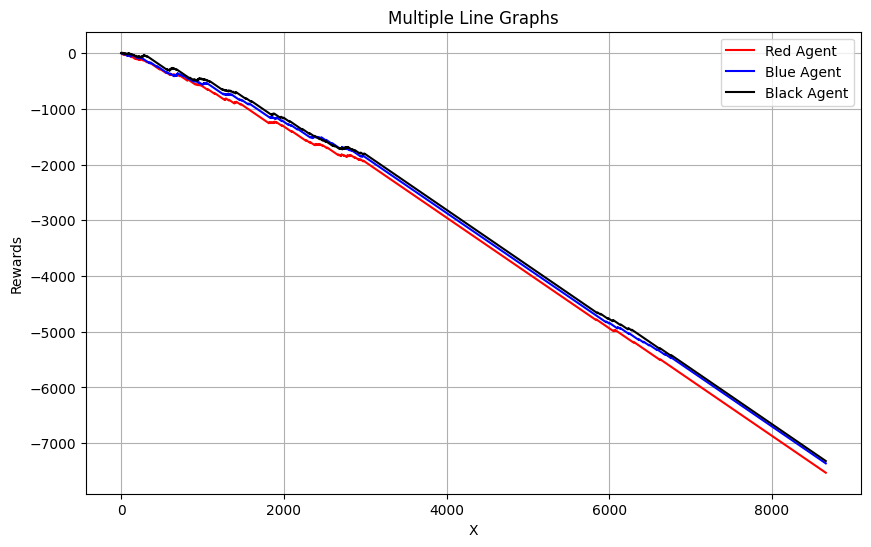

In [34]:
environment_rows=5
environment_cols=5
num_actions = 6
learning_rate = 0.3
discount_factor = 0.5

redAgent = Agent(0)
redAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blueAgent = Agent(1)
blueAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate,discount_factor)

blackAgent = Agent(2)
blackAgent.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate,discount_factor)


initialEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
testEnvironment =    [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5]
currEnvironment = initialEnvironment
policy = "PRANDOM"

first500 = int(500/3)
for i in range(first500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"First Random Run: {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")
# blackAgent.qtable.print_q_table()


# Second Round
currEnvironment = None
currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
random8500 = int(8500/3)
for i in range(random8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nSecond Run: {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")


# Third Round
currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
greedy8500 = int(8500/3)
policy = "PGREEDY"
for i in range(greedy8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nGreedy Run: {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")


currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent.getReward()}")
print(f"Blue Reward: {blueAgent.getReward()}")
print(f"Black Reward: {blackAgent.getReward()}")


# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

### Experiment 2 
* 1.c except *run SARSA* q-learning variation for 9000 steps

When analyzing Experiment 2 
* Comparing the performance of Q-learning and SARSA
* Report one of the final Q-tables of this experiment
* Also assess the quality of agent coordination, 


Greedy Run: [3, 5, 1, 5, 1, 5, 1, 1, 1, 0, 0, 0, 2, 5, 5]
Red Reward: -2986
Blue Reward: -2986
Black Reward: -2986
Black Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,2)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,3)   |    0.00   0.00   0.00   0.00   0.00   0.00
(0,4)   |    0.00   0.00  -0.30   0.00  -0.30   0.00
(1,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,2)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,3)   |    0.00   0.00   0.00   0.00   0.00   0.00
(1,4)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,1)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,2)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,3)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,4)  

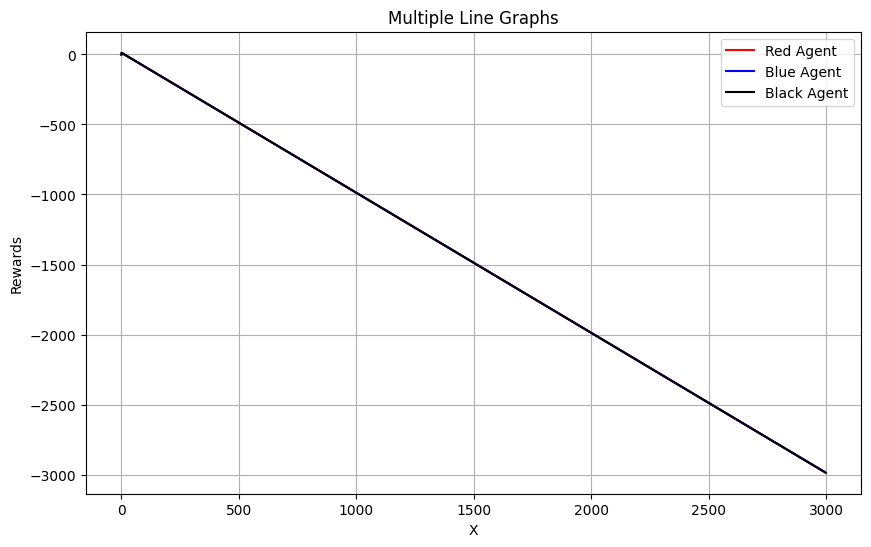

In [36]:
environment_rows=5
environment_cols=5
num_actions = 6
learning_rate = 0.3
discount_factor = 0.5

redAgent2 = Agent(0)
redAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate, discount_factor)

blueAgent2 = Agent(1)
blueAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate,discount_factor)

blackAgent2 = Agent(2)
blackAgent2.setAgentQTable(environment_rows, environment_cols, num_actions, learning_rate,discount_factor)

currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit9000 = int(9000/3)
policy = "PEXPLOIT"
for i in range(exploit9000):
    currEnvironment = redAgent2.stepS(currEnvironment, policy)
    currEnvironment = blueAgent2.stepS(currEnvironment, policy)
    currEnvironment = blackAgent2.stepS(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nGreedy Run: {currEnvironment}")
print(f"Red Reward: {redAgent2.getReward()}")
print(f"Blue Reward: {blueAgent2.getReward()}")
print(f"Black Reward: {blackAgent2.getReward()}")
print("Black Agent QTable")
blackAgent2.qtable.print_q_table()


# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent2.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent2.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent2.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

### Experiment 3 
rerun either  Experiment 1.c or 2 with learning rates:
* 0.15 
* 0.45

When interpreting the results focus on analyzing the effects of using the 3 different learning rates on the system performance. 
##### We will be rerunning experiment 1.c


Exploit Run: [1, 4, 4, 5, 2, 4, 0, 0, 0, 5, 2, 3, 0, 0, 5]
Red Reward: -2805
Blue Reward: -2749
Black Reward: -2665
Black Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.15   0.00  -0.28  -0.15
(0,1)   |    0.00   0.00  -0.28  -0.15  -0.28  -0.28
(0,2)   |    0.00   0.00  -0.29  -0.29  -0.40  -0.29
(0,3)   |    1.94   0.00  -0.40  -0.29  -0.41  -0.29
(0,4)   |    0.00   0.00  -0.28  -0.28  -0.49   0.00
(1,0)   |    0.00   0.00   0.00   0.00  -0.15   0.00
(1,1)   |    0.00   0.00  -0.15   0.00  -0.15  -0.15
(1,2)   |    0.00   0.00  -0.15  -0.15  -0.28  -0.15
(1,3)   |    0.00   0.00  -0.28  -0.15  -0.28  -0.15
(1,4)   |    0.00   0.00  -0.15  -0.15  -0.39   0.00
(2,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,1)   |    0.00   0.00   0.00   0.00  -0.15   0.00
(2,2)   |    0.00   0.00   0.00   0.00  -0.15   0.00
(2,3)   |    0.00   0.00  -0.15   0.00  -0.15   0.00
(2,4) 

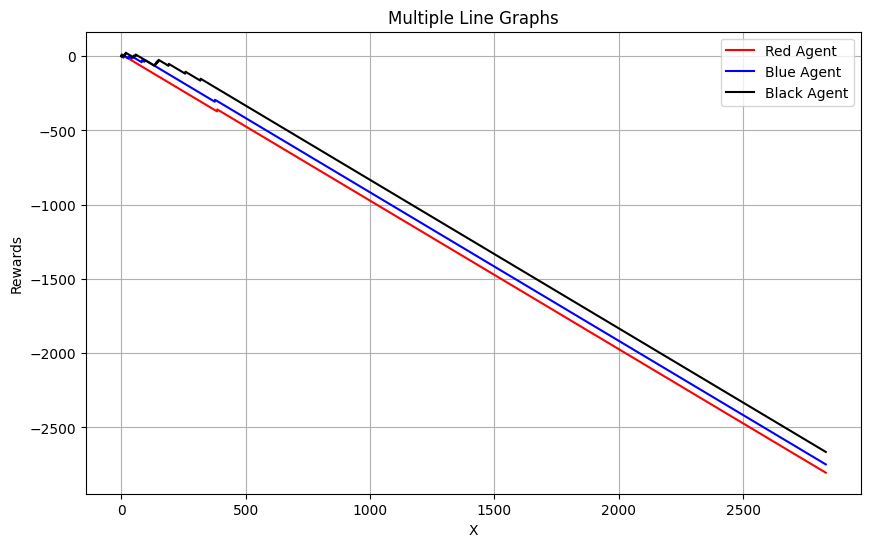


Exploit Run: [2, 5, 1, 3, 1, 2, 0, 0, 0, 5, 3, 2, 0, 0, 5]
Red Reward: -2749
Blue Reward: -2721
Black Reward: -2749
Black Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.70   0.00  -0.83  -0.70
(0,1)   |    0.00   0.00  -0.80  -0.93  -0.93  -0.45
(0,2)   |    0.00   0.00  -0.80  -0.80  -0.93  -0.80
(0,3)   |    5.85   0.00  -0.83  -0.70  -0.93  -0.45
(0,4)   |    0.00   0.00  -0.70  -0.70  -0.80   0.00
(1,0)   |    0.00   5.85  -0.45   0.00  -0.70  -0.45
(1,1)   |    0.00   0.00  -0.45  -0.70  -0.70  -0.45
(1,2)   |    0.00   0.00  -0.45  -0.45  -0.70  -0.45
(1,3)   |    0.00   0.00  -0.70  -0.45  -0.70   0.00
(1,4)   |    0.00   0.00  -0.45  -0.45  -0.45   0.00
(2,0)   |    0.00   0.00   0.00   0.00  -0.45   0.00
(2,1)   |    0.00   0.00   0.00  -0.45  -0.45   0.00
(2,2)   |    0.00   0.00   0.00   0.00  -0.45   0.00
(2,3)   |    0.00   0.00  -0.45   0.00  -0.45   0.00
(2,4) 

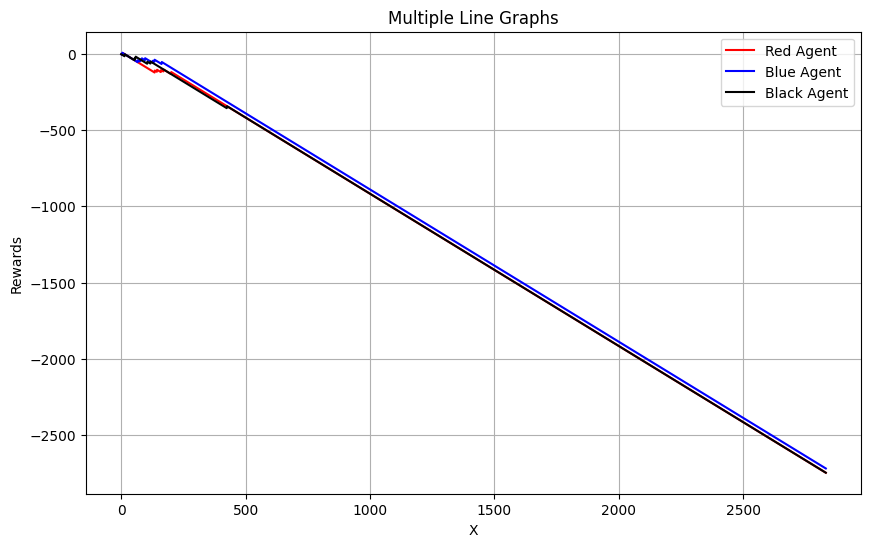

In [38]:
environment_rows=5
environment_cols=5
num_actions = 6
a1 = 0.15         # learning rate 1
a2 = 0.45         # learning rate 2
discount_factor = 0.5

redAgent3a1 = Agent(0)
redAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blueAgent3a1 = Agent(1)
blueAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blackAgent3a1 = Agent(2)
blackAgent3a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent3a1.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent3a1.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent3a1.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent3a1.getReward()}")
print(f"Blue Reward: {blueAgent3a1.getReward()}")
print(f"Black Reward: {blackAgent3a1.getReward()}")

print("Black Agent QTable")
blackAgent3a1.qtable.print_q_table()

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent3a1.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent3a1.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent3a1.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


redAgent3a2 = Agent(0)
redAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blueAgent3a2 = Agent(1)
blueAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blackAgent3a2 = Agent(2)
blackAgent3a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent3a2.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent3a2.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent3a2.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent3a2.getReward()}")
print(f"Blue Reward: {blueAgent3a2.getReward()}")
print(f"Black Reward: {blackAgent3a2.getReward()}")

print("Black Agent QTable")
blackAgent3a2.qtable.print_q_table()


# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent3a2.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent3a2.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent3a2.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

### Experiment 4 
is the somewhat similar to Experiment 1c use:
* a=0.3 
* a=0.5 

in conjunction with either Q-learning or SARSA  as follows: 
1. run PRANDOM for the first 500 steps
2. run PEXPLOIT 
3. when, a terminal state is reached the third time change the three pickup locations to: (4,2), (3,3) and (2,4)
4. run PEXPLOIT with the “new” pickup locations until the agent reaches a terminal state the sixth time. 

When interpreting the results of this experiment center on analyzing on how well the learning strategy was able to adapt to the change of the pickup locations and to which extend it was able to learn “new” paths and unlearn “old” paths which became obsolete.

##### We Will be using Experiment 1c


Exploit Run: [1, 5, 2, 2, 2, 4, 0, 0, 0, 5, 3, 4, 3, 0, 0]
Red Reward: -5580
Blue Reward: -5412
Black Reward: -5426
Black Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.15   0.00  -0.28  -0.15
(0,1)   |    0.00   0.00  -0.28  -0.15  -0.40  -0.39
(0,2)   |    0.00   0.00  -0.42  -0.41  -0.53  -0.42
(0,3)   |    1.94   0.00  -0.40  -0.70  -0.41  -0.29
(0,4)   |    0.00   0.00  -0.39  -0.62  -0.39   0.00
(1,0)   |    0.00   1.95   0.00   0.00  -0.15   0.00
(1,1)   |    0.00   0.00  -0.15   0.00  -0.28  -0.28
(1,2)   |    0.00   0.00  -0.29  -0.28  -0.42  -0.29
(1,3)   |    0.00   0.00  -0.28  -0.64  -0.28  -0.15
(1,4)   |    0.00   0.00  -0.28  -0.56  -0.39   0.00
(2,0)   |    0.00   0.00   0.00   0.00   0.00   0.00
(2,1)   |    1.95   0.00   0.00   0.00  -0.15  -0.15
(2,2)   |    0.00   0.00  -0.15  -0.15  -0.31  -0.15
(2,3)   |    0.00   0.00  -0.15  -0.57  -0.15   0.00
(2,4) 

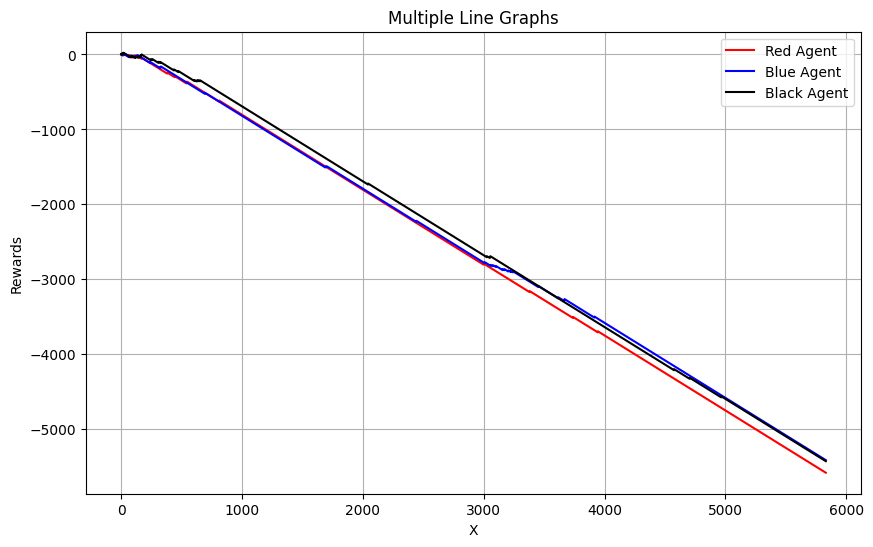


Exploit Run: [2, 3, 1, 5, 1, 2, 0, 0, 0, 5, 1, 5, 4, 0, 0]
Red Reward: -5510
Blue Reward: -5552
Black Reward: -5468
Black Agent QTable
Q-table:
State   |     P       D      N      E      S      W
------------------------------------------------------
(0,0)   |    0.00   0.00  -0.83   0.00  -0.83  -0.70
(0,1)   |    0.00   0.00  -0.93  -0.80  -1.01  -0.93
(0,2)   |    0.00   0.00  -0.80  -1.01  -1.01  -0.93
(0,3)   |    5.67   0.00  -1.07  -1.20  -1.14  -1.07
(0,4)   |    0.00   0.00  -0.45  -0.83  -0.89   0.00
(1,0)   |    0.00   5.85  -0.70   0.00  -0.70  -0.45
(1,1)   |    0.00   0.00  -0.70  -0.45  -0.83  -0.70
(1,2)   |    5.85   0.00  -0.45  -0.83  -0.83  -0.70
(1,3)   |    0.00   0.00  -0.80  -1.04  -0.93  -0.80
(1,4)   |    0.00   0.00  -0.70  -0.70  -0.80   0.00
(2,0)   |    0.00   0.00  -0.45   0.00  -0.45   0.00
(2,1)   |    9.07   0.00  -0.45   0.00  -0.70  -0.45
(2,2)   |    0.00   0.00   0.00  -0.70  -0.70  -0.45
(2,3)   |    0.00   0.00  -0.45  -0.89  -0.70  -0.45
(2,4) 

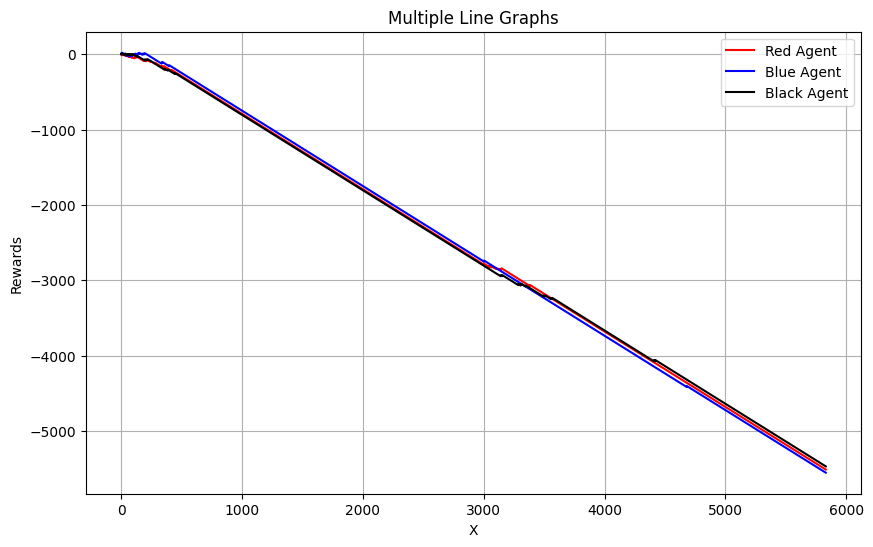

In [39]:
environment_rows=5
environment_cols=5
num_actions = 6
a1 = 0.15         # learning rate 1
a2 = 0.45         # learning rate 2
discount_factor = 0.5

# TEST WITH ALPHA 1
redAgent4a1 = Agent(0)
redAgent4a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blueAgent4a1 = Agent(1)
blueAgent4a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

blackAgent4a1 = Agent(2)
blackAgent4a1.setAgentQTable(environment_rows, environment_cols, num_actions, a1, discount_factor)

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
random500 = int(500/3)
policy = "PRANDOM"
for i in range(random500):
    currEnvironment = redAgent4a1.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4a1.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4a1.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4a1.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4a1.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4a1.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4a1.stepQ4(currEnvironment, policy)
    currEnvironment = blueAgent4a1.stepQ4(currEnvironment, policy)
    currEnvironment = blackAgent4a1.stepQ4(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent4a1.getReward()}")
print(f"Blue Reward: {blueAgent4a1.getReward()}")
print(f"Black Reward: {blackAgent4a1.getReward()}")

print("Black Agent QTable")
blackAgent4a1.qtable.print_q_table()


# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent4a1.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent4a1.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent4a1.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


# TEST WITH ALPHA 2
redAgent4a2 = Agent(0)
redAgent4a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blueAgent4a2 = Agent(1)
blueAgent4a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

blackAgent4a2 = Agent(2)
blackAgent4a2.setAgentQTable(environment_rows, environment_cols, num_actions, a2, discount_factor)

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
random500 = int(500/3)
policy = "PRANDOM"
for i in range(random500):
    currEnvironment = redAgent4a2.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4a2.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4a2.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4a2.stepQ(currEnvironment, policy)
    currEnvironment = blueAgent4a2.stepQ(currEnvironment, policy)
    currEnvironment = blackAgent4a2.stepQ(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

currEnvironment = [3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
exploit8500 = int(8500/3)
finishCount = 0
policy = "PEXPLOIT"
for i in range(exploit8500):
    currEnvironment = redAgent4a2.stepQ4(currEnvironment, policy)
    currEnvironment = blueAgent4a2.stepQ4(currEnvironment, policy)
    currEnvironment = blackAgent4a2.stepQ4(currEnvironment, policy)
    if(finishCheck(currEnvironment)):
        finishCount += 1
        currEnvironment=[3,3,5,3,1,3,0,0,0,0,0,0,5,5,5]
        if(finishCount == 3):
            break

print(f"\nExploit Run: {currEnvironment}")
print(f"Red Reward: {redAgent4a2.getReward()}")
print(f"Blue Reward: {blueAgent4a2.getReward()}")
print(f"Black Reward: {blackAgent4a2.getReward()}")

print("Black Agent QTable")
blackAgent4a2.qtable.print_q_table()


# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(redAgent4a2.getRewardList(), color = 'red', label='Red Agent')
plt.plot(blueAgent4a2.getRewardList(), color = 'blue', label='Blue Agent')
plt.plot(blackAgent4a2.getRewardList(), color = 'black', label='Black Agent')

# Add labels and title
plt.xlabel('X')  # X-axis label
plt.ylabel('Rewards')  # Y-axis label
plt.title('Multiple Line Graphs')  # Plot title

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()